<a href="https://colab.research.google.com/github/sagar2582/Crude-OIL-future-prediction-/blob/main/Crude_OIL_prediction_using_Stacked_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Data Collection
import pandas_datareader as pdr

In [ ]:
# Creating a request in json format

import requests

headers = {
        'Content-Type': 'application/json'
        }
requestResponse = requests.get("https://api.tiingo.com/api/test?token=037a2939c8cb9f249170032a4a185db726955008",
                                    headers=headers)
print(requestResponse.json())
key = "037a2939c8cb9f249170032a4a185db726955008"

{'message': 'You successfully sent a request'}


In [ ]:
df = pdr.get_data_tiingo('OIL', api_key=key)

/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [ ]:
# Converting json to csv format

df.to_csv('OIL.csv')

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('OIL.csv')

In [ ]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,OIL,2017-06-15 00:00:00+00:00,13.4701,13.6000,13.4701,13.6000,1443,13.4701,13.6000,13.4701,13.6000,1443,0.0,1.0
1,OIL,2017-06-16 00:00:00+00:00,13.6045,13.6045,13.6045,13.6045,121,13.6045,13.6045,13.6045,13.6045,121,0.0,1.0
2,OIL,2017-06-19 00:00:00+00:00,13.6045,13.6045,13.6045,13.6045,38,13.6045,13.6045,13.6045,13.6045,38,0.0,1.0
3,OIL,2017-06-20 00:00:00+00:00,13.1500,13.1500,13.1500,13.1500,534,13.1500,13.1500,13.1500,13.1500,534,0.0,1.0
4,OIL,2017-06-21 00:00:00+00:00,12.8550,12.8550,12.8550,12.8550,511,12.8550,12.8550,12.8550,12.8550,511,0.0,1.0


In [ ]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,OIL,2022-06-07 00:00:00+00:00,38.62,38.8000,37.9811,38.18,89528,38.62,38.8000,37.9811,38.18,89528,0.0,1.0
1254,OIL,2022-06-08 00:00:00+00:00,39.61,39.7400,38.6300,38.75,88884,39.61,39.7400,38.6300,38.75,88884,0.0,1.0
1255,OIL,2022-06-09 00:00:00+00:00,39.26,39.6099,39.0210,39.60,55159,39.26,39.6099,39.0210,39.60,55159,0.0,1.0
1256,OIL,2022-06-10 00:00:00+00:00,38.70,39.1300,38.0500,38.78,56034,38.70,39.1300,38.0500,38.78,56034,0.0,1.0
1257,OIL,2022-06-13 00:00:00+00:00,38.83,39.1800,37.5271,39.14,147049,38.83,39.1800,37.5271,39.14,147049,0.0,1.0


## As we can see we have got Data from 2017 - 2022 for the crude OIL commodity
### Now we will be using the column "close" -> (Closing price of crude OIL on a particular day) for the particular time-series problem.

In [ ]:
# storing all the values in the "close" column 
df_close = df.reset_index()['close']

In [ ]:
df_close.shape

(1258,)

## We have 1258 records

In [ ]:
df_close

0       13.4701
1       13.6045
2       13.6045
3       13.1500
4       12.8550
         ...   
1253    38.6200
1254    39.6100
1255    39.2600
1256    38.7000
1257    38.8300
Name: close, Length: 1258, dtype: float64

## Plotting the end points

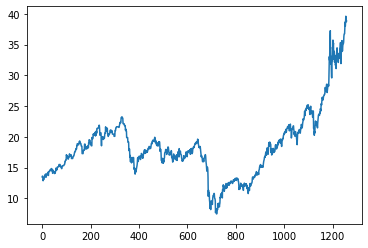

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_close)
plt.show()

### LSTM are sensitive to the scale of the data. So we have to apply MinMax scaler to transform our values in [0,1.

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_close=scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [ ]:
df_close  # Transformed into an array - values ranging from 0 - 1

array([[0.18693935],
       [0.19111975],
       [0.19111975],
       ...,
       [0.98911353],
       [0.97169518],
       [0.97573872]])

## Spiltting the data in train and test sets

In [ ]:
training_size=int(len(df_close)*0.70)
test_size=len(df_close)-training_size
train_data,test_data=df_close[0:training_size,:],df_close[training_size:len(df_close),:1]

In [ ]:
# length of the data
training_size,test_size

(880, 378)

## Data Pre-Processing

In [ ]:
#  function for the forcast which updates with the new predicted value

import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

We will be using the previous 100 features to predict or fit in our LSTM model, as in the function above, the newly predicted output will be appended in the end our data. 

In [ ]:
# Now checking the distribution among test and train
print(X_train.shape), print(y_train.shape)

(779, 100)
(779,)


(None, None)

In [ ]:
print(X_test.shape), print(y_test.shape)

(277, 100)
(277,)


(None, None)

### Before implementing any LSTM model we need to reshape our inputs to a 3-dimensions

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fitting into the model
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 10s 107ms/step - loss: 0.0236 - val_loss: 0.0538
Epoch 2/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0135
Epoch 3/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0027 - val_loss: 0.0098
Epoch 4/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0106
Epoch 5/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 6/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 7/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 8/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 9/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 10/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.00

In [ ]:
import tensorflow as tf

In [ ]:
# Now the prediction and checking performance metrics

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
# Transformback to original form (reverse scaling) - to find the RMSE performance metrics, it is neccessary 

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
# Calculating RMSE performance metrics

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

549.6294943068544

In [ ]:
# Test Data RMSE score

math.sqrt(mean_squared_error(y_test,test_predict))

836.6746412357068

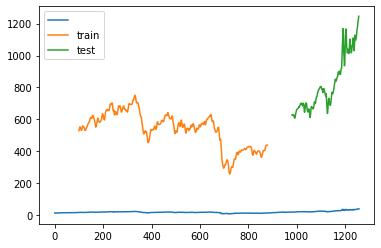

In [ ]:
### Plotting 

# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df_close)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['','train', 'test'])
plt.show()

## Now Working on the next 20 days forcast

In [ ]:
len(test_data)

378

In [ ]:
# To predict what will be the price of crude OIL on next day, we will look back on the 100 days

x_input=test_data[278:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 20 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<20):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9523343]
101
1 day input [0.58227061 0.57636081 0.58662519 0.5940902  0.59751166 0.59906687
 0.60435459 0.60404355 0.60559876 0.61866252 0.63981337 0.63452566
 0.6192846  0.62488336 0.62426128 0.64821151 0.6562986  0.62457232
 0.61399689 0.62830482 0.63732504 0.64634526 0.65536547 0.65692068
 0.64634526 0.67247278 0.73810264 0.79564541 0.77698289 0.83794712
 0.88678072 0.92690513 0.78662519 0.75863142 0.79751166 0.75023328
 0.69300156 0.68802488 0.76267496 0.77356143 0.84323484 0.83313841
 0.87931571 0.85194401 0.86469673 0.78227061 0.79875583 0.82301711
 0.77076205 0.76765163 0.80248834 0.78040435 0.75241058 0.75645412
 0.7645661  0.73530327 0.78880249 0.81586314 0.83017107 0.84012442
 0.79533437 0.80155521 0.81337481 0.7881804  0.76609642 0.7881804
 0.78693624 0.80514463 0.79595645 0.81026439 0.78942457 0.83856921
 0.84199067 0.86687403 0.79024883 0.76049767 0.80808709 0.82301711
 0.85412131 0.87682737 0.84817729 0.82363919 0.84105754 0.85723173
 0.86127527 0.86127527 0.8681182  0

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,121)

In [ ]:
import matplotlib.pyplot as plt
len(df_close)

1258

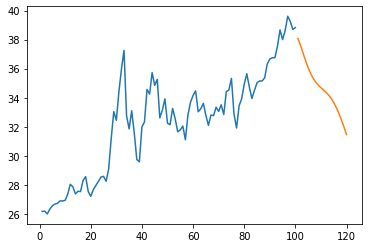

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df_close[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

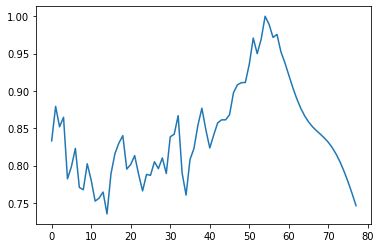

In [ ]:
df1=df_close.tolist()
df1.extend(lst_output)
plt.plot(df1[1200:])
plt.show()

In [ ]:
df1=scaler.inverse_transform(df1).tolist()

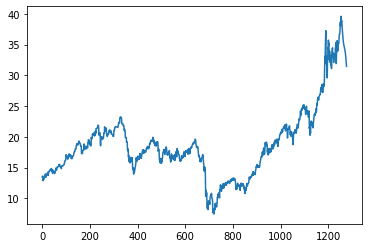

In [ ]:
plt.plot(df1)
plt.show()